### Singlephotoelectron mini analysis: windows identification

The plugIn for getting the LED data can be find here: https://github.com/XENONnT/straxen/blob/led_plugin/straxen/plugins/led_calibration.py.

The motivation for this analysis is to estimate the SPE acceptance using low-intensity LED runs.

Before using the plugin, the LED windwos and the noise window have to be indentificated.

In [1]:
%run '/home/gvolta/XENONnT/LedAnalysis/Initialization_for_SPE.py'

0.0.8


In [2]:
runs = st.select_runs(run_mode='LED*')
#runs

Checking data availability: 100%|██████████| 5/5 [00:26<00:00,  5.12s/it]


#### Determining LED and noise window:
- Identify the rough amplitude range corresponding to a single photoelectron;
- Find the time window in which we have an excess of sample in this amplitude range;
- Define the noise window far from the LED window.

In [3]:
# The LED and the noise window are computed
# using the raw record. The the straxen.config
# of LEDCalibration pulgin will be modified

run_id = '180219_1049'
data_rr = st.get_array(run_id, 'raw_records', seconds_range=(0,20))

In [4]:
datatype = [('pmt', np.int16),
            ('Amplitude', np.float32),
            ('Sample of Amplitude', np.float32)]

Data = np.zeros((len(data_rr)), dtype = datatype)

for i in range(len(data_rr)):
    Data[i]['pmt'] = data_rr['channel'][i]
    Data[i]['Amplitude'] = np.max(data_rr['data'][i])
    Data[i]['Sample of Amplitude'] = np.argmax(data_rr['data'][i])

In [5]:
window, info, df2 = SPErough(data = Data)

  0%|          | 1/248 [00:00<00:43,  5.66it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:733: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 248/248 [00:08<00:00, 28.93it/s]


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


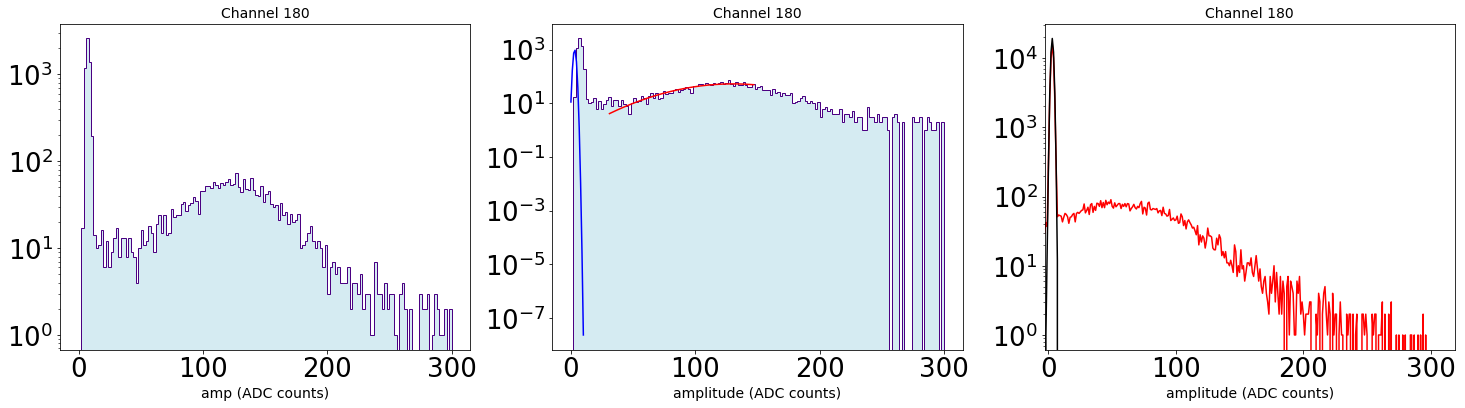

<Figure size 432x288 with 0 Axes>

In [6]:
plt.figure(figsize=(25,6))
n_channel = 180

plt.subplot(131)
plt.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
plt.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='step', color='indigo')
plt.yscale('log')
plt.title('Channel %d' %n_channel)
plt.xlabel('amp (ADC counts)')

ax = plt.subplot(132)
ax.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
hist, xbins, _ = ax.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, 
                         range=(0,300), histtype='step', color='indigo')

xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
idx_0PE_argmax = np.argmax(hist)
temp = hist[(idx_0PE_argmax+4):]
idx_1PE_argmax = np.argmax(temp) + (idx_0PE_argmax+4)

low = 15 
high = idx_1PE_argmax + 10
x = np.linspace(xbins_center[low], xbins_center[high], 20) 
ax.plot(x, gaus(x, info['LED_norm'][n_channel], info['LED_mu'][n_channel], info['LED_sigma'][n_channel]), 'r-')

x = np.linspace(0, 10, 10)  
ax.plot(x, gaus(x, info['noise_norm'][n_channel], info['noise_mu'][n_channel], info['noise_sigma'][n_channel]), 'b-')

ax.set_yscale('log')
ax.set_ylim(bottom = 0)
ax.set_title('Channel %d' %n_channel)
ax.set_xlabel('amplitude (ADC counts)')

ax2 = plt.subplot(133)
N = 50000 
occ = 0.2 
if (info['LED_mu'][n_channel] > 0):
    LED_vals = (sp.stats.norm.rvs(loc=info['noise_mu'][n_channel], scale=info['noise_sigma'][n_channel], size=N) + 
                sp.stats.norm.rvs(loc=info['LED_norm'][n_channel], scale=info['LED_sigma'][n_channel], size=N) * sp.stats.poisson.rvs(occ, size=N))
    LED, bins = np.histogram(LED_vals, bins=400, range=(-100.5, 299.5))
    bins = 0.5 * (bins[1:] + bins[:-1])
    ax2.plot(bins, LED, color='red', label='LED')
    
noise_vals = sp.stats.norm.rvs(loc=info['noise_mu'][n_channel], scale=info['noise_sigma'][n_channel], size=N)
noise, bins = np.histogram(noise_vals, bins=400, range=(-100.5, 299.5))
bins = 0.5 * (bins[1:] + bins[:-1])

ax2.plot(bins, noise, color='black', label='noise')
ax2.set_title('Channel %d' %n_channel)
ax2.set_xlabel('amplitude (ADC counts)')
ax2.set_yscale('log')
ax2.set_ylim(bottom = 0)
ax2.set_xlim(left = -3)

plt.show()
plt.tight_layout()

mean:  162.95775 	 standard deviation:  50.318783


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


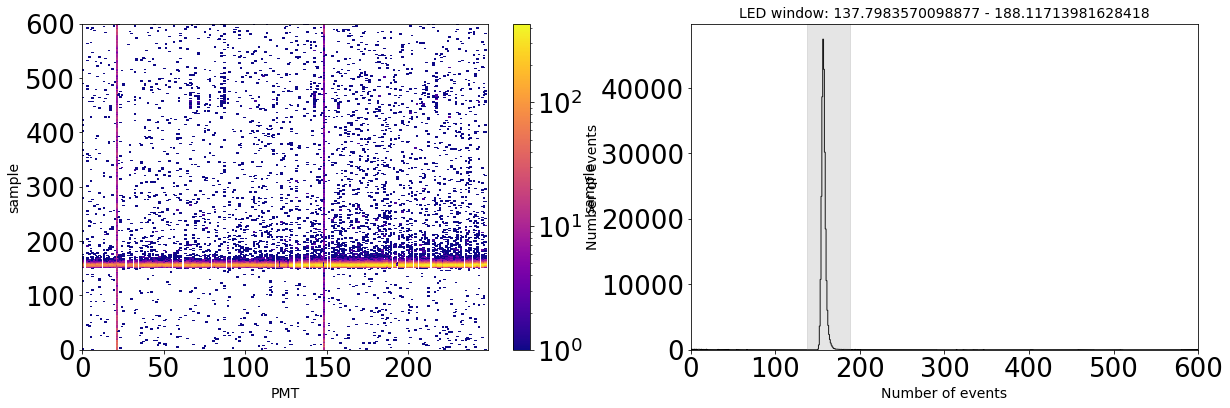

<Figure size 432x288 with 0 Axes>

In [7]:
fig = plt.figure(figsize=(20,6))

######################################################################################################
plt.subplot(121)
hist2d, xbins, ybins, _ = plt.hist2d(x = df2['channel'], y = df2['idx_LED'], 
                                     bins=(249,600), range=((0,249),(0,600)), 
                                     cmap=plt.cm.plasma, norm=mpl.colors.LogNorm(), cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('PMT')
plt.ylabel('sample')
######################################################################################################

######################################################################################################
plt.subplot(122)
y_hist, y_bins, _ = plt.hist(df2['idx_LED'], bins=600, range=(0,600), histtype='step', color='black')
#plt.yscale('log')
plt.xlim(0,600)
mean = df2['idx_LED'].mean()
std = df2['idx_LED'].std()
window = [int(mean-0.5*std),int(mean+0.5*std)]
print('mean: ',mean,'\t standard deviation: ', std)
plt.axvspan(*window, color='grey', alpha=0.2)
plt.title('LED window: '+str(mean-0.5*std)+' - '+str(mean+0.5*std))
plt.xlabel('Number of events')
plt.ylabel('sample')
######################################################################################################

plt.show()
plt.tight_layout()